### SPARK: TIME ANALYSIS

## Description
3 studies on the data provided in the file tripdata_2017_01.csv
    1. Average speed of taxis in terms of the hour
    2. Most common taxi trips
    3. Financial records (tips, persons, etc)
We are going to use Spark's API (RDDs), dataframes and direct SQL.

In [1]:
pip install findspark

Note: you may need to restart the kernel to use updated packages.


In [60]:
import findspark
findspark
from pyspark.sql import SparkSession

#we are going to crate a SparkSession with the name "lab_spark"
spark = SparkSession.builder.appName("lab_spark").master("local[*]").getOrCreate()#the * means we are using all the cores

#obtain the SparkContext from the SparkSession
spark_context = spark.sparkContext

#libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
#import pickle

#import functions and classes from pyspark.sql
from pyspark.sql.functions import col, round,concat,lit, expr, from_unixtime, unix_timestamp, date_format, count
from pyspark.sql.types import IntegerType #module to work with integer data types

In [3]:
#we need to calculate the time it takes to read the data
start_time = time.time()

Now, we are going to read the dataset of the taxis

In [4]:
#this is for the CSV attached in the assignment
#taxi_data_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").option("timestampFormat", "yyyy-MM-dd HH:mm:ss").option("mode", "PERMISSIVE").load(r"./tripdata_2017_01.csv") 
#taxi_data_df.show(5)

#this is with the final CSV (parquet file)
taxi_data_df = spark.read.parquet('yellow_tripdata_2024-01.parquet')
taxi_data_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



In [5]:
end_time = time.time()
time_to_read=(end_time - start_time)#time it takes to read the data

In [6]:
print('Time it takes to read the data with Spark dataframes: ', time_to_read)

Time it takes to read the data with Spark dataframes:  3.7142913341522217


In [7]:
#taxi_data_df.describe().show()

Now, let's clean the data

In [8]:
#we need to calculate the time it takes to clean the data
start_time = time.time()

We are going to calculate the total duration of each trip and remove the ones that have a duration of 0

In [9]:
taxi_data_df = taxi_data_df.withColumn("trip_time_hours", round((unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))) / 3600, 2)) #calculate the trip time in hours
taxi_data_df = taxi_data_df.filter(col('trip_time_hours') >= 0)

In [10]:
#now let's count how many of them do we have

In [11]:
taxi_data_df.count()

2964587

We are going to remove rows <=0 (tip_amount, total_amount, fare_amount, mta_tax)

In [12]:
#filter values of tips and other taxes lower than 0

#for column in ["tip_amount", "tolls_amount", "improvement_surcharge", "total_amount"]:
    #taxi_data_df = taxi_data_df.filter(col(column) >= 0)
#¡¡¡¡¡¡¡¡DUDA DE SI total_amount Y fare_amount SOLO DESCARTAR LOS >0 Y DEJAR LOS =0!!!!!!!!!!!!!!!!!

for column in ['tip_amount', 'mta_tax']:
    taxi_data_df = taxi_data_df.filter(taxi_data_df[column] >= 0)

In [13]:
for column in ['fare_amount', 'total_amount']:
        taxi_data_df = taxi_data_df.filter(taxi_data_df[column] > 0)

In [14]:
taxi_data_df.count()

2926246

In [15]:
end_time = time.time()
time_data_cleaning = end_time - start_time#time it takes to clean the data
print('Time it takes to clean the data with Spark dataframes: ', time_data_cleaning)

Time it takes to clean the data with Spark dataframes:  8.434823274612427


### **STUDY 1: AVERAGE SPEED OF TAXIS IN TERMS OF THE HOUR**

In this study, we will calculate the average speed of New York taxis for each hour of the day to analyze traffic patterns in the city. This analysis has been conducted using dataframes, RDD, SQL, and Pandas. The steps we followed are as follows:

    1. Convert trip distance from miles to kilometers.
    2. Calculate speed by dividing the trip distance by the previously calculated trip duration.
    3. Group the data by the hour of the day and compute the average speed.
    4. Finally, we plot the results.

**With RDD**

In [16]:
taxi_df = taxi_data_df.alias('taxi_df')
taxi_df.show(3)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|trip_time_hours|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         1|                 N|         186|          79|

In [40]:
#function to calculate the time elapsed in hours to know the duration of the trips
def calculate_elapsed_hours(start_time, end_time):
    time_diff = (end_time - start_time).total_seconds() / 3600
    return np.round(time_diff, 3)

In [42]:
# Select required columns once instead of multiple times
taxi_rdd = taxi_df.select('trip_distance', 'tpep_pickup_datetime', 'tpep_dropoff_datetime').rdd.map(lambda row: (row[0], row[1], row[2]))

# Convert trip distance to kilometers and calculate trip duration in hours in one step
distance_time_rdd = taxi_rdd.map(lambda x: (np.round(x[0] * 1.609344, 3), calculate_elapsed_hours(x[1], x[2]), x[1]))

# Calculate speed and extract hour from pickup time in the same step
speed_hour_rdd = distance_time_rdd.map(lambda x: (
    np.round(x[0] / x[1], 3) if x[1] > 0 else 0,  # Speed in km/h
    x[2].hour                                     # Extract hour from pickup time (x[2] is pickup time)
))

# Filter out zero-speed trips
speed_hour_rdd = speed_hour_rdd.filter(lambda x: x[0] > 0)

# Combine total speed and trip count for each hour in one pass using mapValues and reduceByKey
hour_speed_count_rdd = speed_hour_rdd.map(lambda x: (x[1], (x[0], 1))) \
                                     .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

# Calculate average speed per hour
avg_speed_per_hour_rdd = hour_speed_count_rdd.map(lambda x: (x[0], np.round(x[1][0] / x[1][1], 3)))

# Collect results
start_time = time.time()
avg_speed_per_hour_list = avg_speed_per_hour_rdd.collect()

# Amount of data processed
data_processed = taxi_rdd.count()  # Count total records processed

end_time = time.time()
execution_time = end_time - start_time

# Print the result
for hour, avg_speed in sorted(avg_speed_per_hour_list):
    print(f'Hour: {hour}, Avg Speed: {avg_speed} km/h')

print(f'Execution time for Spark RDD task: {execution_time:.2f} seconds')
print(f'Amount of data processed: {data_processed} records')


Hour: 0, Avg Speed: 25.196 km/h
Hour: 1, Avg Speed: 24.555 km/h
Hour: 2, Avg Speed: 22.947 km/h
Hour: 3, Avg Speed: 24.872 km/h
Hour: 4, Avg Speed: 32.142 km/h
Hour: 5, Avg Speed: 62.059 km/h
Hour: 6, Avg Speed: 93.609 km/h
Hour: 7, Avg Speed: 52.319 km/h
Hour: 8, Avg Speed: 27.091 km/h
Hour: 9, Avg Speed: 18.291 km/h
Hour: 10, Avg Speed: 19.766 km/h
Hour: 11, Avg Speed: 20.991 km/h
Hour: 12, Avg Speed: 19.418 km/h
Hour: 13, Avg Speed: 17.383 km/h
Hour: 14, Avg Speed: 19.607 km/h
Hour: 15, Avg Speed: 20.148 km/h
Hour: 16, Avg Speed: 17.164 km/h
Hour: 17, Avg Speed: 16.738 km/h
Hour: 18, Avg Speed: 17.164 km/h
Hour: 19, Avg Speed: 19.229 km/h
Hour: 20, Avg Speed: 21.453 km/h
Hour: 21, Avg Speed: 22.101 km/h
Hour: 22, Avg Speed: 22.558 km/h
Hour: 23, Avg Speed: 25.12 km/h
Execution time for Spark RDD task: 79.95 seconds
Amount of data processed: 2926246 records


In [22]:
first_values = [x[0] for x in avg_speed_per_hour_list]

# Second list for the second elements (average speeds)
second_values = [x[1] for x in avg_speed_per_hour_list]

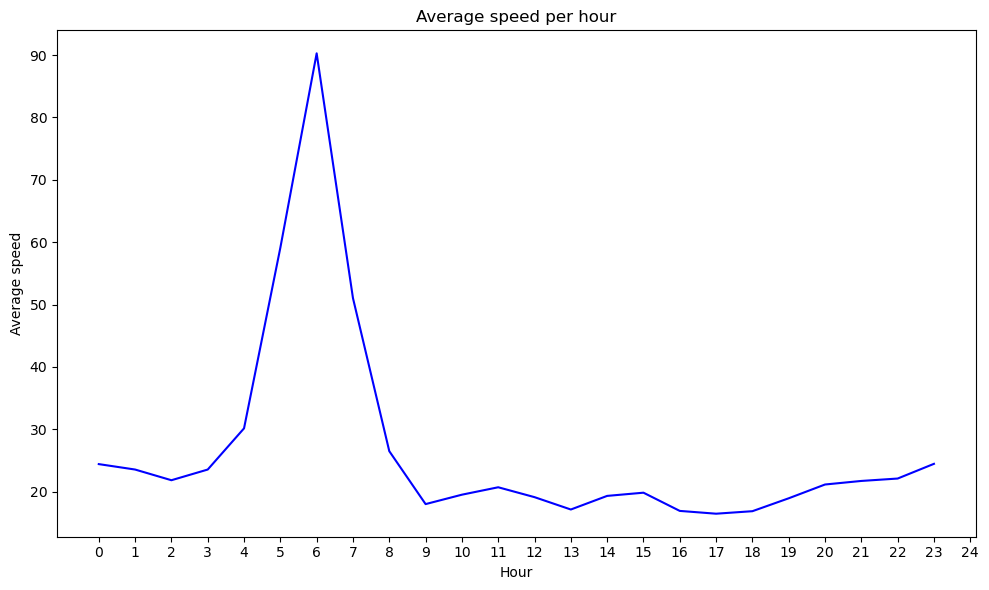

In [43]:
# Initialize a new figure with a defined size (10 inches wide by 6 inches tall)
fig, ax = plt.subplots(figsize=(10, 6))

#line plot, using hours for the x-axis and average speed for the y-axis
sns.lineplot(x=first_values, y=second_values, ax=ax, color='blue')

ax.set_xlabel("Hour")
ax.set_ylabel("Average speed")
ax.set_title("Average speed per hour")
ax.set_xticks(range(25))
ax.set_xticklabels(range(25), rotation=0)

plt.tight_layout()
plt.show()

**With dataframes**

In [24]:
taxi_df = taxi_data_df.alias('taxi_data_df')
taxi_df.show(3)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|trip_time_hours|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         1|                 N|         186|          79|

In [36]:
dropoff_df = taxi_data_df.select('tpep_dropoff_datetime')
pickup_df = taxi_data_df.select('tpep_pickup_datetime')

taxi_df = taxi_data_df.withColumn("trip_distance_km", round(taxi_data_df["trip_distance"] * 1.609344, 3))

taxi_df = taxi_df.withColumn("trip_duration_hours", (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 3600)

taxi_df = taxi_df.withColumn("trip_speed_km_h", round(taxi_df['trip_distance_km'] / taxi_df['trip_duration_hours'], 3))

# Extract the hour from pickup datetime and format it
taxi_df = taxi_df.withColumn("hour_time", date_format(taxi_df["tpep_pickup_datetime"], "HH"))

# Group by hour and calculate average trip speed
hours_speed_df = taxi_df.groupBy("hour_time").agg({"trip_speed_km_h": "mean"})

hours_speed_df = hours_speed_df.withColumn("hour_time", hours_speed_df["hour_time"].cast(IntegerType()))

start_time = time.time()
hours_speed_df_pd = hours_speed_df.toPandas()
end_time = time.time()

# Amount of data processed
data_processed = taxi_df.count()  # Total number of records in filtered DataFrame

task1_spark_df_time = end_time - start_time
print('Execution time for Spark DataFrames task:' + str(task1_spark_df_time) + ' seconds')
print('Amount of data processed: ' + str(data_processed) + ' records')

Execution time for Spark DataFrames task: 3.778262138366699
Amount of data processed: 2926246records


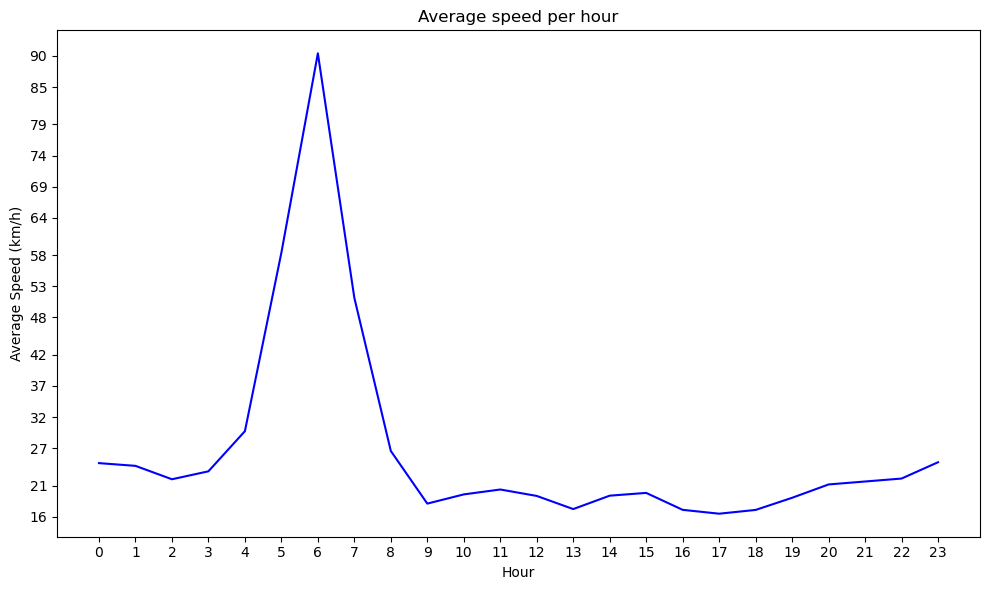

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

# Line plot, using hours for the x-axis and average speed for the y-axis
sns.lineplot(x="hour_time", y="avg(trip_speed_km_h)", data=hours_speed_df_pd, ax=ax, color='blue')

ax.set_xlabel("Hour")
ax.set_ylabel("Average Speed (km/h)")
ax.set_title("Average speed per hour")

ax.set_xticks(range(0, 24))
ax.set_xticklabels(range(0, 24), rotation=0)

#minimum and maximum speed for y-ticks
min_value = np.round(hours_speed_df_pd["avg(trip_speed_km_h)"].min())
max_value = np.round(hours_speed_df_pd["avg(trip_speed_km_h)"].max())
ysticks_ = np.unique(np.round(np.linspace(min_value, max_value, 15)))

ax.set_yticks(ysticks_)
plt.tight_layout()
plt.show()


**With SQL**

In [27]:
taxi_df = taxi_data_df.alias('taxi_data_df')
taxi_df.show(3)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|trip_time_hours|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         1|                 N|         186|          79|

In [28]:
# Create temporary views for SQL queries
taxi_data_df.createOrReplaceTempView("taxi_data")

# Use SQL to calculate trip distances in kilometers, duration, speed, and extract hour
sql_query = """
SELECT 
    tpep_pickup_datetime,
    tpep_dropoff_datetime,
    ROUND(trip_distance * 1.609344, 3) AS trip_distance_km,
    (UNIX_TIMESTAMP(tpep_dropoff_datetime) - UNIX_TIMESTAMP(tpep_pickup_datetime)) / 3600 AS trip_duration_hours,
    ROUND(ROUND(trip_distance * 1.609344, 3) / ((UNIX_TIMESTAMP(tpep_dropoff_datetime) - UNIX_TIMESTAMP(tpep_pickup_datetime)) / 3600), 3) AS trip_speed_km_h,
    DATE_FORMAT(tpep_pickup_datetime, 'HH') AS hour_time
FROM taxi_data
"""

# Execute the SQL query and create a new DataFrame
taxi_df = spark.sql(sql_query)

# Group by hour and calculate average trip speed
hours_speed_df = taxi_df.groupBy("hour_time").agg({"trip_speed_km_h": "mean"})

# Convert the "hour_time" column to integer type
hours_speed_df = hours_speed_df.withColumn("hour_time", hours_speed_df["hour_time"].cast(IntegerType()))

# Measure execution time for the SQL operation
start_time = time.time()
hours_speed_df_pd = hours_speed_df.toPandas()  # Convert the DataFrame to a Pandas DataFrame for further analysis
end_time = time.time()

# Calculate and print the execution time
task1_spark_sql_time = end_time - start_time
print('Execution time for Spark SQL task:', task1_spark_sql_time)


Execution time for Spark SQL task: 4.3401899337768555


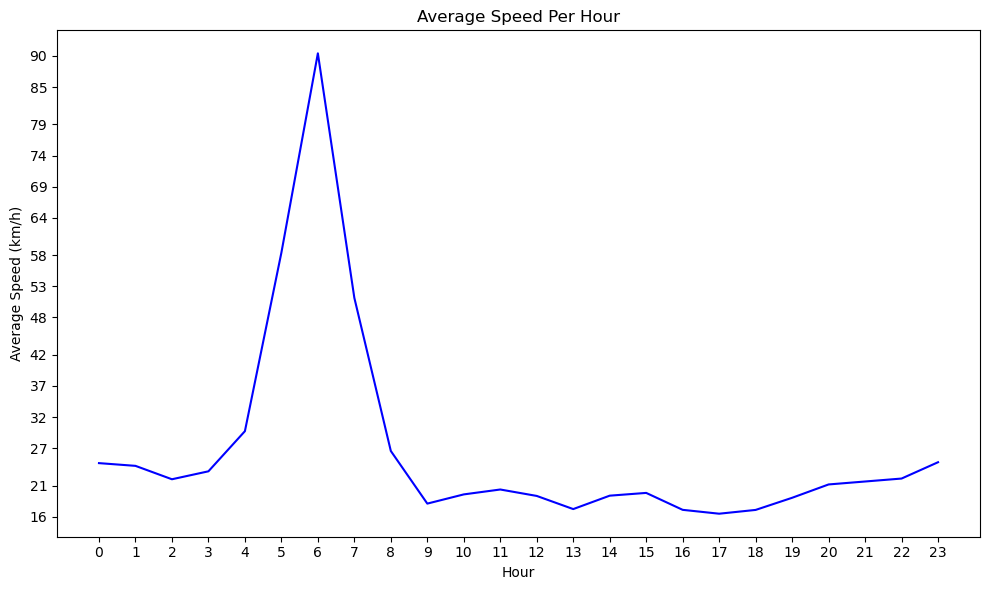

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(x="hour_time", y="avg(trip_speed_km_h)", data=hours_speed_df_pd, ax=ax, color='blue')

ax.set_xlabel("Hour")
ax.set_ylabel("Average Speed (km/h)")
ax.set_title("Average Speed Per Hour")

#x-ticks to represent each hour of the day
ax.set_xticks(range(0, 24))
ax.set_xticklabels(range(0, 24), rotation=0)

#minimum and maximum average speeds for y-ticks
min_value = np.round(hours_speed_df_pd["avg(trip_speed_km_h)"].min())
max_value = np.round(hours_speed_df_pd["avg(trip_speed_km_h)"].max())
ysticks_ = np.unique(np.round(np.linspace(min_value, max_value, 15)))

ax.set_yticks(ysticks_)
plt.tight_layout()
plt.show()

#### **Analysis**

Here we are going to analize the execution time and processin speed on the different processes.
- We are going to compare this task with different number of cores: 1,2 and 4.

In [30]:
cores = np.array([1, 2, 3, 4])

#here we create the arrays with the value of each measurement for different cores
data_cleaning_time = np.array([10.46617865, 6.895304203, 6.802240372, 5.7345814704895])
study1_time_rdd = np.array([47.79272771, 36.873281, 41.82206416, 40.1774652])
study1_time_df = np.array([7.202777386, 5.028202295, 4.640931129, 4.050532579])
study1_time_sql = np.array([6.500316143, 4.172153711, 4.565528631, 3.060003519])

time_dataframe = dict()
time_dataframe['cores'] = cores
time_dataframe['data_cleaning_time'] = data_cleaning_time
time_dataframe['study1_time_rdd'] = study1_time_rdd
time_dataframe['study1_time_df'] = study1_time_df
time_dataframe['study1_time_sql'] = study1_time_sql

time_dataframe = pd.DataFrame(time_dataframe)

print(time_dataframe)

   cores  data_cleaning_time  study1_time_rdd  study1_time_df  study1_time_sql
0      1           10.466179        47.792728        7.202777         6.500316
1      2            6.895304        36.873281        5.028202         4.172154
2      3            6.802240        41.822064        4.640931         4.565529
3      4            5.734581        40.177465        4.050533         3.060004


In the following plot we can see the difference between RDD, dataframes and SQL, in terms of excecution time depending on the number of cores used

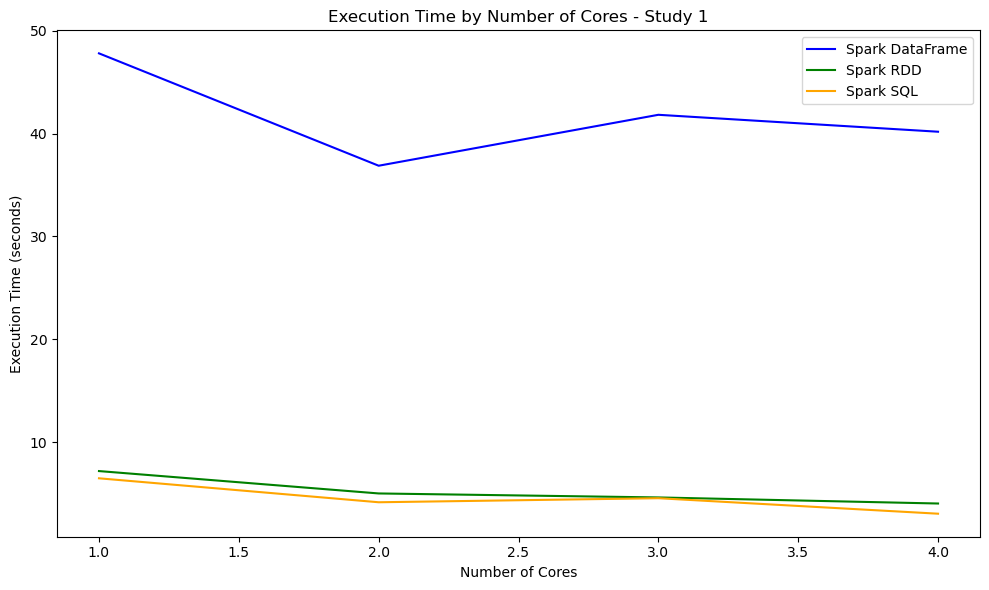

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(x='cores', y='study1_time_rdd', data=time_dataframe, ax=ax, color='blue', label='Spark DataFrame')
sns.lineplot(x='cores', y='study1_time_df', data=time_dataframe, ax=ax, color='green', label='Spark RDD')
sns.lineplot(x='cores', y='study1_time_sql', data=time_dataframe, ax=ax, color='orange', label='Spark SQL')

ax.set_xlabel("Number of Cores")
ax.set_ylabel("Execution Time (seconds)")
ax.set_title("Execution Time by Number of Cores - Study 1")

ax.tick_params(axis='x', rotation=0)

ax.legend()
fig.tight_layout()

plt.show()

Then, we are asked to compute the processing speed. This is done by dividing the execution time of one core by the execution time of all cores.

In [32]:
df_speed_up = pd.DataFrame()

df_speed_up['cores'] = time_dataframe['cores']

for column in time_dataframe.drop(columns='cores'):
    one_core_time = time_dataframe[time_dataframe['cores'] == 1][column].values[0]
    speed_up_values = time_dataframe[column].apply(lambda x: one_core_time / x)
    df_speed_up[column] = speed_up_values

print(df_speed_up)

   cores  data_cleaning_time  study1_time_rdd  study1_time_df  study1_time_sql
0      1            1.000000         1.000000        1.000000         1.000000
1      2            1.517870         1.296134        1.432476         1.558024
2      3            1.538637         1.142763        1.552011         1.423782
3      4            1.825099         1.189541        1.778230         2.124284


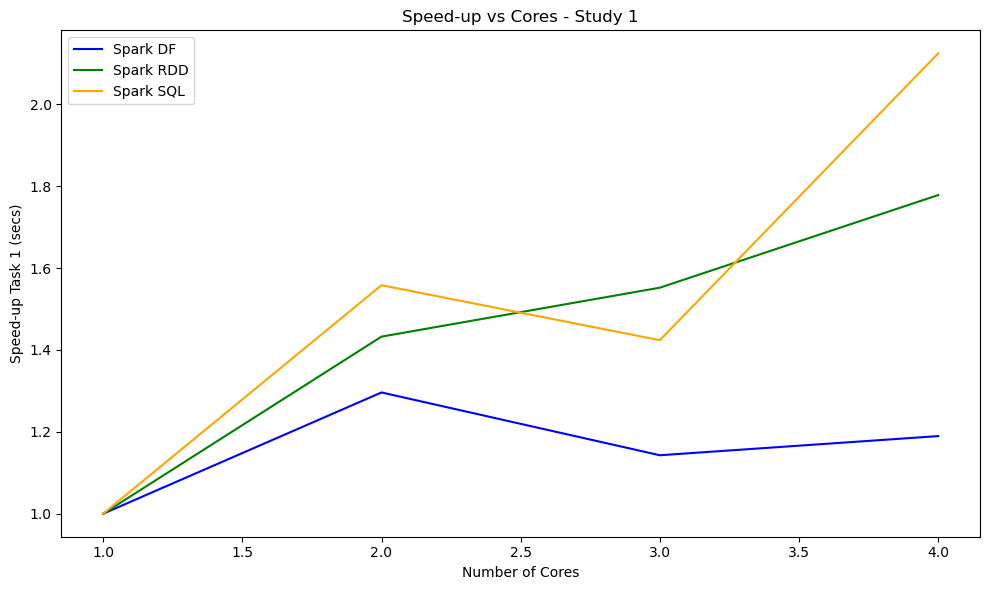

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(x='cores', y='study1_time_rdd', data=df_speed_up, ax=ax, color='blue', label='Spark DF')
sns.lineplot(x='cores', y='study1_time_df', data=df_speed_up, ax=ax, color='green', label='Spark RDD')
sns.lineplot(x='cores', y='study1_time_sql', data=df_speed_up, ax=ax, color='orange', label='Spark SQL')

ax.set_xlabel("Number of Cores")
ax.set_ylabel("Speed-up Task 1 (secs)")
ax.set_title("Speed-up vs Cores - Study 1")

ax.tick_params(axis='x', rotation=0)
ax.legend()
plt.tight_layout()
plt.show()

### **STUDY 2: MOST COMMON TAXI TRIPS**

In this study, we examined the most common taxi rides, using Spark Dataframe for our analysis. We have also used the file "taxi_zone_lookup.csv" that provides us more information about the zones from the taxi trips.

We are going to filter the unknown trips in the "taxi_zone_lookup.csv" file and then gruop by pickup and dropoff location ids. Both datasets are going to be joined.

In [71]:
zones_df = (spark.read.format("csv").option("inferSchema", "true").option("timestampFormat", "yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(r"./taxi_zone_lookup.csv"))

filter_zones_df = zones_df.filter(col('LocationID') < 264)

# Group taxis data by Pickup and Dropoff Location IDs and count trips
grouped_taxis_df = (taxi_df.groupBy('PULocationID', 'DOLocationID')
                    .agg(count('*').alias('trip_count'))
                    .orderBy(col('trip_count').desc()))

# Inner join for Pickup locations
PU_joined_df = (grouped_taxis_df
    .join(filter_zones_df, grouped_taxis_df['PULocationID'] == filter_zones_df['LocationID'], 'inner')
    .select('PULocationID', 'DOLocationID', 'LocationID', 'trip_count', 'Borough', 'Zone')
    .withColumnRenamed('Borough', 'Borough_PU')
    .withColumnRenamed('Zone', 'Zone_PU')
    .withColumnRenamed('trip_count', 'trip_count_PU'))

# Inner join for Dropoff locations
DO_joined_df = (grouped_taxis_df
    .join(filter_zones_df, grouped_taxis_df['DOLocationID'] == filter_zones_df['LocationID'], 'inner')
    .select('PULocationID', 'DOLocationID', 'LocationID', 'trip_count', 'Borough', 'Zone')
    .withColumnRenamed('Borough', 'Borough_DO')
    .withColumnRenamed('Zone', 'Zone_DO'))

# Combine the two joined DataFrames on Pickup and Dropoff locations
zones_trips_df = (PU_joined_df.join(DO_joined_df, (PU_joined_df['PULocationID'] == DO_joined_df['PULocationID']) & (PU_joined_df['DOLocationID'] == DO_joined_df['DOLocationID']), 'inner').select('Borough_PU', 'Zone_PU', 'Borough_DO', 'Zone_DO', 'trip_count'))

# Sort the final DataFrame by trip_count in descending order
sorted_zones_trips_df = zones_trips_df.orderBy(col('trip_count').desc())

start_time = time.time()
sorted_zones_trips_df.show(10)
end_time = time.time()
study2_df_time = end_time - start_time

# Amount of data processed
data_processed = grouped_taxis_df.count()  # Total number of records in the original DataFrame

# Processing speed (records per second)
processing_speed = data_processed / study2_df_time if study2_df_time > 0 else float('inf')

print('Time study 2 with Spark dataframes: ' + str(study2_df_time) + ' s')
print('Amount of data processed: ' + str(data_processed) + ' records')
print('Processing speed: ' + str(processing_speed) + ' records/s')


+----------+--------------------+----------+--------------------+----------+
|Borough_PU|             Zone_PU|Borough_DO|             Zone_DO|trip_count|
+----------+--------------------+----------+--------------------+----------+
| Manhattan|Upper East Side S...| Manhattan|Upper East Side N...|     21708|
| Manhattan|Upper East Side N...| Manhattan|Upper East Side S...|     19269|
| Manhattan|Upper East Side N...| Manhattan|Upper East Side N...|     15626|
| Manhattan|Upper East Side S...| Manhattan|Upper East Side S...|     14559|
| Manhattan|      Midtown Center| Manhattan|Upper East Side S...|     10170|
| Manhattan| Lincoln Square East| Manhattan|Upper West Side S...|      8883|
| Manhattan|Upper East Side S...| Manhattan|      Midtown Center|      8752|
| Manhattan|      Midtown Center| Manhattan|Upper East Side N...|      8703|
| Manhattan|Upper West Side S...| Manhattan| Lincoln Square East|      8595|
| Manhattan|Upper West Side S...| Manhattan|Upper West Side N...|      8366|

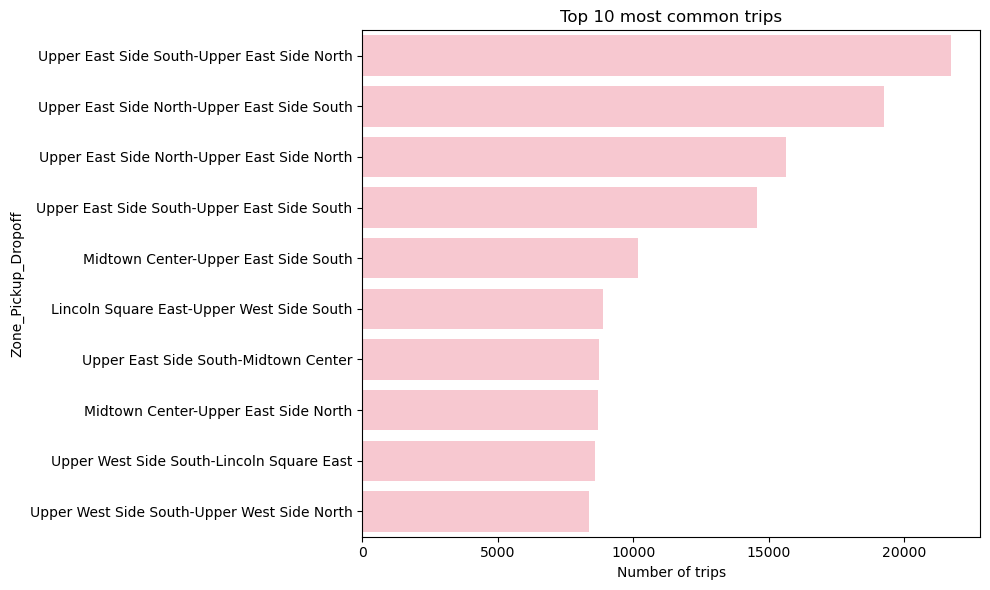

In [73]:
sorted_zones_trips_df = sorted_zones_trips_df.withColumn('Zone_Pickup_Dropoff', concat(col('Zone_PU'), lit('-'), col('Zone_DO')))
sorted_zones_trips_df_pandas = sorted_zones_trips_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(y="Zone_Pickup_Dropoff", x="trip_count", data=sorted_zones_trips_df_pandas.head(10), color='pink')
plt.xlabel("Number of trips")
plt.ylabel("Zone_Pickup_Dropoff")
plt.title("Top 10 most common trips")
plt.xticks(rotation=0) 
plt.tight_layout()
plt.show()

In [ ]:
### **STUDY 2: MOST COMMON TAXI TRIPS**